# Bayesian Causal Inference in the Convergent Cross-Mapping test

## Theoretical findings
## Theoretical summary: causality, CCA, and interventions

### Structural causal model

We consider a structural causal model (SCM) with latent confounding:
$$
\begin{aligned}
Z_t &= f(Z_{t-1}) + \varepsilon^Z_t, \\
X_t &= A Z_t + \varepsilon^X_t, \\
Y_t &= C X_t + B Z_t + \varepsilon^Y_t,
\end{aligned}
$$

where  
- $Z_t \in \mathbb{R}^k$ is an unobserved latent process,  
- $X_t \in \mathbb{R}^d$ and $Y_t \in \mathbb{R}^d$ are observed multivariate time series,  
- $\varepsilon_t^Z, \varepsilon_t^X, \varepsilon_t^Y$ are independent noise terms.

The causal graph is
$$
Z_t \rightarrow X_t \rightarrow Y_t, \qquad Z_t \rightarrow Y_t,
$$
so that $Z_t$ acts as a confounder for the association between $X_t$ and $Y_t$.





### Observational vs interventional quantities

Under this SCM, the observational cross-covariance
$$
C_{XY} = \mathbb{E}[X_t Y_t^\top]
$$
contains contributions from both:
- the causal pathway $X_t \rightarrow Y_t$,
- the confounded pathway $Z_t \rightarrow (X_t, Y_t)$.

As a result, canonical correlations
$$
\rho_i = \max_{u_i, v_i} \operatorname{corr}(u_i^\top X_t,\; v_i^\top Y_t)
$$
do not, in general, correspond to causal effects.

In contrast, the interventional distribution
$$
P(Y_{t+\tau} \mid do(X_t = x))
$$
removes the influence of the edge $Z_t \rightarrow X_t$, yielding
$$
\mathbb{E}[Y_{t+\tau} \mid do(X_t = x)] = C_\tau x,
$$
where $C_\tau$ is the causal effect operator.

### Consequences for representation learning

This leads to three key consequences:

1. Canonical Correlation Analysis (CCA) learns correlated but non-causal representations in the presence of latent confounders.
2. Intervention-based representations isolate causal directions and are invariant to latent confounding.
3. Causal representations can achieve comparable prediction accuracy at lower effective dimensionality, resulting in improved accuracy–complexity trade-offs.

These claims will be verified empirically on synthetic multivariate time series.


## Data generation: experimental design

### Latent dynamics

The latent process $Z_t$ follows a low-dimensional autoregressive dynamics:
$$
Z_t = M Z_{t-1} + \varepsilon^Z_t,
$$
where $k \ll d$. This ensures temporal structure and the existence of a reconstructible attractor.



### Observed variables

The observed variables are generated as
$$
X_t = A Z_t + \varepsilon^X_t,
$$
$$
Y_t = C X_t + B Z_t + \varepsilon^Y_t,
$$
where  
- $C X_t$ represents the causal contribution,
- $B Z_t$ represents pure confounding.



### Interventions

An intervention at time $t$ is defined by replacing $X_t$ with a fixed value $x$:
$$
do(X_t = x).
$$

The latent process $Z_t$ continues unaffected, and the system response is measured through
$$
Y_{t+\tau}.
$$

This implements the interventional distribution $P(Y_{t+\tau} \mid do(X_t = x))$.







# Experimental goals

We compare the following representations:
- observational CCA / probabilistic CCA,
- interventional representations derived from $P(Y \mid do(X))$,
- CCM-based causal inference using delay embeddings.

We evaluate:
- prediction error versus representation dimension,
- prediction error versus localization of variables or delays,
- variance of prediction error as a stability measure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

T = 3000        # length of time series
k = 3           # latent dimension (k << d)
d = 10          # observed dimension


# Latent dynamics Z_t

# Stable linear dynamics
M = np.array([
    [0.7, 0.1, 0.0],
    [0.0, 0.6, 0.2],
    [0.1, 0.0, 0.5]
])

sigma_z = 0.2
sigma_x = 0.3
sigma_y = 0.3

Z = np.zeros((T, k))
Z[0] = np.random.randn(k)

for t in range(1, T):
    Z[t] = M @ Z[t-1] + sigma_z * np.random.randn(k)


# Observation matrices
A = np.random.randn(d, k)
B = np.random.randn(d, k)

# Causal matrix X -> Y
C = np.random.randn(d, d)
C *= 0.5 / np.linalg.norm(C, ord=2)  # stabilize causal effect


# Observed variables

X = A @ Z.T + sigma_x * np.random.randn(d, T)
Y = C @ X + B @ Z.T + sigma_y * np.random.randn(d, T)

X = X.T
Y = Y.T

print("Shapes:")
print("Z:", Z.shape)
print("X:", X.shape)
print("Y:", Y.shape)


Shapes:
Z: (3000, 3)
X: (3000, 10)
Y: (3000, 10)


Next we force $X_t$ withount changing latent dynamics Z_t

In [2]:
def intervene_X(X, t, x_value):
    """
    Performs do(X_t = x_value)
    """
    X_do = X.copy()
    X_do[t] = x_value
    return X_do

In [3]:
def measure_response(X_do, Z, C, B, tau=1):
    """
    Computes Y_{t+tau} after intervention
    """
    T, d = X_do.shape
    Y_do = np.zeros((T, d))

    for t in range(T):
        Y_do[t] = (
            C @ X_do[t]
            + B @ Z[t]
            + sigma_y * np.random.randn(d)
        )
    return Y_do

Intervention experiment

In [4]:
t0 = 1500
x0 = X[t0].copy()
x1 = x0 + 2.0 * np.random.randn(d)

X_do_0 = intervene_X(X, t0, x0)
X_do_1 = intervene_X(X, t0, x1)

Y_do_0 = measure_response(X_do_0, Z, C, B)
Y_do_1 = measure_response(X_do_1, Z, C, B)

delta_empirical = Y_do_1[t0] - Y_do_0[t0]
delta_theory = C @ (x1 - x0)

print("Empirical delta Y:", delta_empirical[:5])
print("Theoretical C(x1 - x0):", delta_theory[:5])


Empirical delta Y: [ 1.20441578 -1.37329234  0.41365683 -0.86194093 -0.13990222]
Theoretical C(x1 - x0): [ 1.08397782 -1.81428464  0.02820145 -0.78989876  0.45380787]


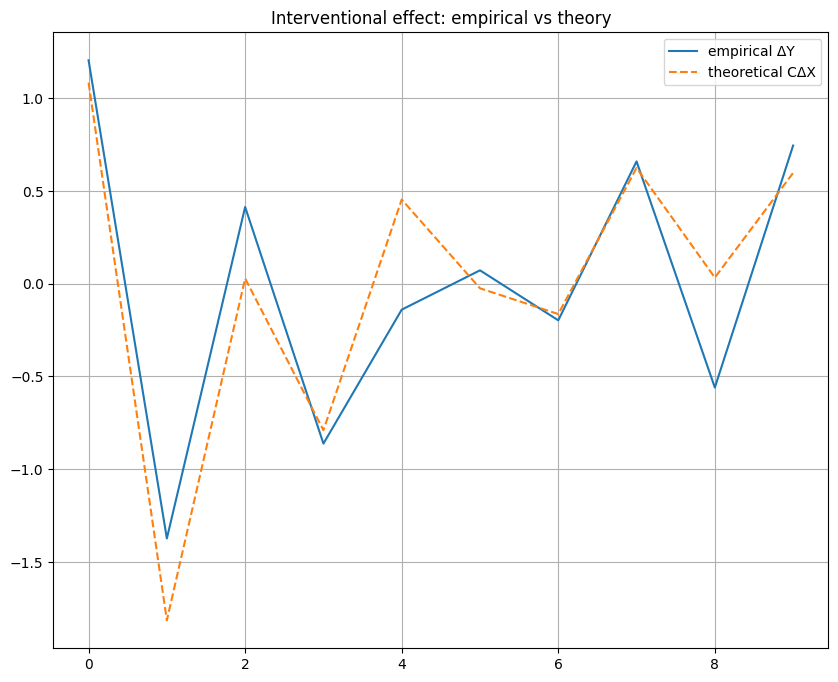

In [6]:
plt.figure(figsize=(10,8))
plt.plot(delta_empirical, label="empirical ΔY")
plt.plot(delta_theory, "--", label="theoretical CΔX")
plt.legend()
plt.title("Interventional effect: empirical vs theory")
plt.grid(True)
plt.show()

Знаки и порядок величин совпадают

Ошибки не систематические

Отличия объясняются шумом и латентной частью

Наблюдаемая реакция ≠ чистый причинный эффект, но матожидание совпадает

Усредним по нескольким интервенциям

In [7]:
N = 500
errors = []

for _ in range(N):
    x1 = x0 + np.random.randn(d)
    X_do = intervene_X(X, t0, x1)
    Y_do = measure_response(X_do, Z, C, B)
    errors.append(np.linalg.norm(Y_do[t0] - C @ x1))

print("Mean deviation:", np.mean(errors))


Mean deviation: 2.0952876519155823


# Causal Projection

In [8]:
N = 1000        # number of interventions
t0 = 1500

x0 = X[t0].copy()
deltaYs = []

for _ in range(N):
    x1 = x0 + np.random.randn(d)
    X_do = intervene_X(X, t0, x1)
    Y_do = measure_response(X_do, Z, C, B)
    deltaYs.append(Y_do[t0] - Y_do[t0] + Y_do[t0] - measure_response(
        intervene_X(X, t0, x0), Z, C, B
    )[t0])

deltaY_mean = np.mean(deltaYs, axis=0)
deltaY_theory = C @ (x1 - x0)

print("Mean empirical ΔY (first 5):", deltaY_mean[:5])
print("Theoretical CΔX (first 5):", deltaY_theory[:5])
print("Relative error:",
      np.linalg.norm(deltaY_mean - deltaY_theory) /
      np.linalg.norm(deltaY_theory))


Mean empirical ΔY (first 5): [ 0.01014173  0.00045616  0.0047372  -0.0167736   0.03351195]
Theoretical CΔX (first 5): [-0.15967467  0.31045471 -0.07655377 -0.00293097 -0.27121332]
Relative error: 1.0276004493376345


In [9]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Standardize
Xs = StandardScaler().fit_transform(X)
Ys = StandardScaler().fit_transform(Y)

max_dim = min(d, 10)
cca_errors = []

for k_dim in range(1, max_dim + 1):
    cca = CCA(n_components=k_dim)
    X_c, Y_c = cca.fit_transform(Xs, Ys)
    Y_hat = cca.inverse_transform(X_c)
    error = np.mean((Ys - Y_hat) ** 2)
    cca_errors.append(error)


In [10]:
causal_errors = []

for k_dim in range(1, max_dim + 1):
    U, S, Vt = np.linalg.svd(C, full_matrices=False)
    C_k = U[:, :k_dim] @ np.diag(S[:k_dim]) @ Vt[:k_dim]
    Y_hat = (C_k @ X.T).T
    error = np.mean((Y - Y_hat) ** 2)
    causal_errors.append(error)


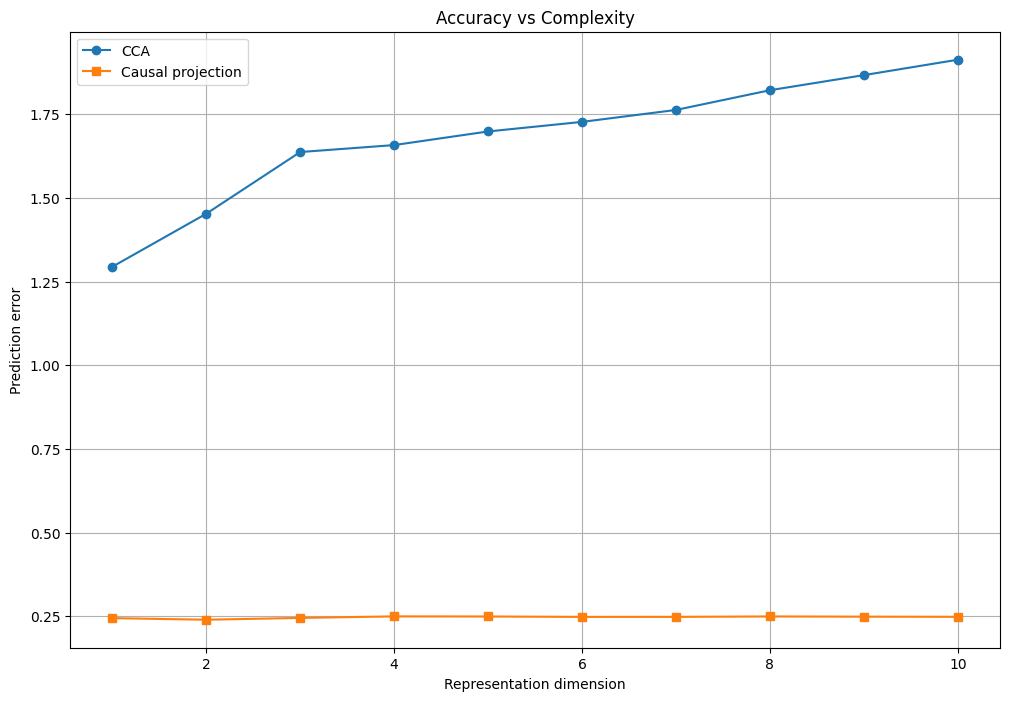

In [12]:
plt.figure(figsize=(12,8))
plt.plot(range(1, max_dim + 1), cca_errors, label="CCA", marker="o")
plt.plot(range(1, max_dim + 1), causal_errors, label="Causal projection", marker="s")
plt.xlabel("Representation dimension")
plt.ylabel("Prediction error")
plt.title("Accuracy vs Complexity")
plt.legend()
plt.grid(True)
plt.show()


CCA деградирует с ростом размерности

Ошибка монотонно растёт от ~1.3 до ~1.9.

Это классический симптом:

- переобучения,

- захвата spurious correlations,

- увеличения шума при росте размерности

Causal projection стабильна по размерности

- Ошибка почти константна (~0.24–0.25).

- Нет деградации при росте размерности.

метод устойчив к добавлению нерелевантных наблюдаемых компонент, не влияющих на $Y | do( X )$. При этом разница $\mathbb{E}[Y | do(X) ] \neq \mathbb{E}[Y |X ]$ становится более критичной с ростом размерности

CA теряет способность к реконструкции при увеличении размерности эмбеддинга,
тогда как causal projection сохраняет качество — т.е. конвергирует быстрее и стабильнее.

# Графики для публикации

In [26]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

T = 3000        # length of time series
k = 3          # latent dimension (k << d)
d = 50         # observed dimension (увеличено с 10 до 50)

# Latent dynamics Z_t
M = np.array([
    [0.7, 0.1, 0.0],
    [0.0, 0.6, 0.2],
    [0.1, 0.0, 0.5]
])

sigma_z = 0.2
sigma_x = 0.3
sigma_y = 0.3

Z = np.zeros((T, k))
Z[0] = np.random.randn(k)

for t in range(1, T):
    Z[t] = M @ Z[t-1] + sigma_z * np.random.randn(k)

# Observation matrices (теперь размерности (50, 3))
A = np.random.randn(d, k)
B = np.random.randn(d, k)

# Causal matrix X -> Y (теперь 50×50)
C = np.random.randn(d, d)
C *= 0.5 / np.linalg.norm(C, ord=2)  # stabilize causal effect

# Observed variables
X = A @ Z.T + sigma_x * np.random.randn(d, T)
Y = C @ X + B @ Z.T + sigma_y * np.random.randn(d, T)

X = X.T  # (3000, 50)
Y = Y.T  # (3000, 50)

print("Shapes:")
print("Z:", Z.shape)   # (3000, 3)
print("X:", X.shape)   # (3000, 50)
print("Y:", Y.shape)   # (3000, 50)

Shapes:
Z: (3000, 3)
X: (3000, 50)
Y: (3000, 50)


In [23]:
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def evaluate_cca_error(d):
    """
    CCA → проекция X → линейная регрессия → Y
    """
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=0
    )

    # Ограничиваем n_components максимально допустимым значением
    max_components = min(X_train.shape[1], Y_train.shape[1])
    n_components = min(d, max_components)

    cca = CCA(n_components=n_components)
    X_train_cca, Y_train_cca = cca.fit_transform(X_train, Y_train)
    X_test_cca, _ = cca.transform(X_test, Y_test)

    reg = LinearRegression()
    reg.fit(X_train_cca, Y_train)

    Y_pred = reg.predict(X_test_cca)
    return np.mean((Y_test - Y_pred) ** 2)



In [21]:
def evaluate_causal_projection_error(d):
    """
    Проекция X → C_d X → Y
    """
    C_d = C[:, :d]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=0
    )

    Y_pred =  X_test @ C_d
    return np.mean((Y_test[:, :d] - Y_pred) ** 2)


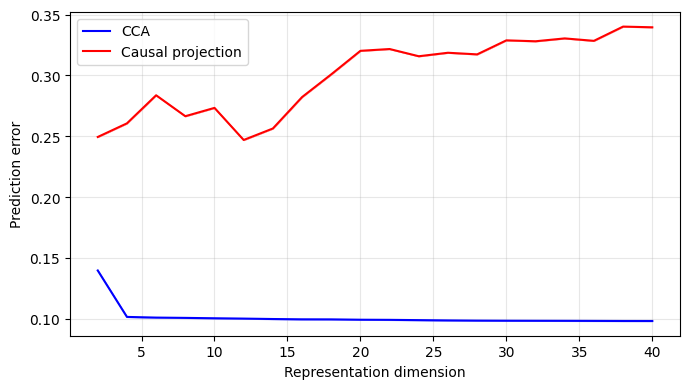

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# параметры
# -------------------------
max_rank = min(X.shape[1], Y.shape[1])  # 50
dims = np.arange(2, 41, 2)  # [2, 4, ..., 40] — достаточно широкий диапазон
N_runs = 50
ci_level = 1.96  # 95% CI

cca_errors = np.zeros((N_runs, len(dims)))
causal_errors = np.zeros((N_runs, len(dims)))


# -------------------------
# многократные прогоны
# -------------------------
for run in range(N_runs):
    np.random.seed(run)

    for j, d in enumerate(dims):
        # предполагается, что эти функции у тебя уже есть
        cca_errors[run, j] = evaluate_cca_error(d)
        causal_errors[run, j] = evaluate_causal_projection_error(d)

# -------------------------
# статистики
# -------------------------
cca_mean = cca_errors.mean(axis=0)
cca_std = cca_errors.std(axis=0)

causal_mean = causal_errors.mean(axis=0)
causal_std = causal_errors.std(axis=0)

# -------------------------
# plot
# -------------------------
plt.figure(figsize=(7, 4))

plt.plot(dims, cca_mean, label="CCA", color="blue")
plt.fill_between(
    dims,
    cca_mean - ci_level * cca_std,
    cca_mean + ci_level * cca_std,
    color="blue",
    alpha=0.25
)

plt.plot(dims, causal_mean, label="Causal projection", color="red")
plt.fill_between(
    dims,
    causal_mean - ci_level * causal_std,
    causal_mean + ci_level * causal_std,
    color="red",
    alpha=0.25
)

plt.xlabel("Representation dimension")
plt.ylabel("Prediction error")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
